# Intro
This notebook shows how to upload model predicted segmentations to Datamint platform. This notebook is based on these documentations:
- [Running Experiments](https://sonanceai.github.io/datamint-python-api/running_experiments.html)
- [Datamint Experiment class](https://sonanceai.github.io/datamint-python-api/datamint.experiment.html)

In [1]:
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np

# Configuration

In [ ]:
%pip install git+https://github.com/SonanceAI/datamint-python-api

If you haven't already, setup your api key:

In [ ]:
# !datamint-config --api-key MY_API_KEY

# Setup-up example Project and data(optional)

creating project

In [2]:
from datamintapi.examples import ProjectMR

PROJECT_NAME = 'Example Project MR'

ProjectMR.create(project_name=PROJECT_NAME)

creating a synthetic segmentation and saving it to 'segmentation.nii.gz'

In [10]:
# The uploaded resource 'emri_small.dcm' has shape (10,64,64) (#frame, H,W).
# default nifti files have shape (W,H,#frame). We need to swap the axes.

seg_array = np.zeros((64, 64, 10), dtype=np.uint8)
seg_array[0:16, 0:16, 0] = 1  # a box in the top-left corner
seg_array[32:, 50, 1] = 1  # horizontal line
seg_nii = nib.Nifti1Image(seg_array, np.eye(4))
nib.save(seg_nii, "segmentation1.nii.gz")

The segmentation looks like this:

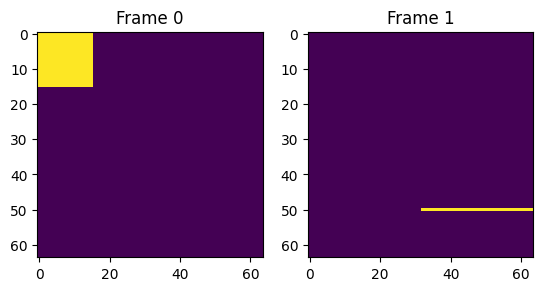

In [11]:
_,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(seg_array[:,:,0].transpose(1,0)) # transpose from (W,H) to (H,W)
ax1.set_title('Frame 0')
ax2.imshow(seg_array[:,:,1].transpose(1,0)) # transpose from (W,H) to (H,W)
ax2.set_title('Frame 1');

# Upload model predicted segmentations

Let's assume the predictions for a single instance have already been made and stored inside a file called `segmentation1.nii.gz`.  
We need to:
1. Create a new experiment
2. Associate a model with this experiment (can be an empty model)
3. Upload the segmentation file to the experiment

## 1. Create a new experiment

In [6]:
from datamintapi import Experiment

exp = Experiment(name='Experiment 1',
                 project_name=PROJECT_NAME,
                 allow_existing=True,  # If an experiment with the same name exists, allow_existing=True returns the existing experiment
                 #  dry_run=True,  # Set dry_run=True to avoid uploading the results to the platform
                 auto_log=False,
                 )

## 2. Associate a model with this experiment

In [7]:
from torch import nn

exp.log_model(nn.Module())  # Log a dummy model. You can log your trained model here.

## 3. Upload the segmentation file to the experiment

In [ ]:
# Retrieve the uploaded resource
from datamintapi import APIHandler

api = APIHandler()

resource = list(api.get_resources(project_name=PROJECT_NAME,
                                  filename='emri_small'))[0]  # returns a dict

resource.keys()

In [3]:
# Alternative for getting the resource ids:

In [ ]:
# Alternative for getting the resource ids:

D = exp.get_dataset(
    project_name=PROJECT_NAME,
    include_unannotated=True, # include unannotated resources, if true.
)
res_id = D.get_resources_ids()[0]

In [ ]:
exp.log_segmentation_predictions(resource['id'],
                                 predictions='segmentation1.nii.gz',
                                 label_name='segmentation_name'  # Specify the name of your segmentation here
                                 )
# OR

- or upload directly using the numpy array:
```python
exp.log_segmentation_predictions(resource['id'],
                                  predictions=seg_array.transpose(2, 1, 0),  # (W,H,#frame) -> (#frame,H,W)
                                  label_name='segmentation_name'
                                  )
```

- You can also upload the segmentation frames one by one:
```python
exp.log_segmentation_predictions(resource['id'],
                                 predictions=seg_array.transpose(2, 1, 0)[0],  # (W,H,#frame) -> (#frame,H,W)
                                 label_name='segmentation_name',
                                 frame_index=0
                                 )
```

- You can also specify segmentation frame from a png file, if you have saved it:
```python
exp.log_segmentation_predictions(resource['id'],
                                 predictions='path/to/mask.png',  # (W,H,#frame) -> (#frame,H,W)
                                 label_name='segmentation_name',
                                 frame_index=0
                                 )
```

- You can also specify a mapping of pixel values to their labels:
```python
exp.log_segmentation_predictions(resource['id'],
                                 predictions='path/to/mask.png',  # (W,H,#frame) -> (#frame,H,W)
                                 label_name={255:'Femur'},
                                 frame_index=0,
                                 predictions_format='multi-class'
                                 )
```
See documentation [here](https://sonanceai.github.io/datamint-python-api/datamint.experiment.html#datamintapi.experiment.experiment.Experiment.log_segmentation_predictions) for more details.